In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
n = 1000    # number of source samples
m = 1500    # number of target samples

# Generate source samples: 1000 points from a 2D Gaussian (mean=0, std=1)
X = np.random.normal(loc = 0, scale = 1, size = (n,2))
a = np.ones(n)/n    # uniform weights to source samples
print(f"Source distribution (n={n}): mean={X.mean():.2f}, std={X.std():.2f}, min={X.min():.2f}, max={X.max():.2f}")

# Target distribution: draw m samples from a 2D bimodal Gaussian (two peaks at -10 and +10)
Y_1 = np.random.normal(loc = -10, scale = 1, size = (m//2, 2))
Y_2 = np.random.normal(loc = 10, scale = 1, size = (m//2, 2))
Y = np.vstack([Y_1, Y_2])
b = np.ones(m)/m    # uniform weights over the target samples
print(f"Target distribution (m={m}): mean={Y.mean():.2f}, std={Y.std():.2f}, min={Y.min():.2f}, max={Y.max():.2f}")

Source distribution (n=1000): mean=-0.01, std=0.98, min=-3.16, max=3.32
Target distribution (m=1500): mean=-0.01, std=10.08, min=-12.97, max=13.24


In [3]:
# Compute the cost matrix 
def compute_cost_matrix(X, Y, p):
  cost_matrix = np.sum(np.abs((X[:, None] - Y[None, :])) ** p, axis=2)
  return cost_matrix

cost_matrix = compute_cost_matrix(X, Y, p=2)

#min-max normalization
cost_matrix_r = np.max(cost_matrix) - np.min(cost_matrix)
cost_matrix_min = np.min(cost_matrix)
cost_matrix = (cost_matrix - cost_matrix_min) / cost_matrix_r

# Print the cost matrix shape and min-max values
print(f"Cost matrix shape: {cost_matrix.shape}")
print(f"Cost matrix min: {np.min(cost_matrix)}")
print(f"Cost matrix max: {np.max(cost_matrix)}")

Cost matrix shape: (1000, 1500)
Cost matrix min: 0.0
Cost matrix max: 1.0


In [4]:
# Search for the smallest epsilon (regularization value) such that the kernel matrix has no zero entries
epsilon_values = np.logspace(-3, 2, num = 200)
for i in range(len(epsilon_values)):
  kernel_matrix = np.exp(-cost_matrix / epsilon_values[i])
  if not np.any(kernel_matrix == 0):
    epsilon = epsilon_values[i]
    break
  
print(f"Epsilon: {epsilon}")

# Print the kernel matrix shape and min-max values
print(f"Kernel matrix shape: {kernel_matrix.shape}")
print(f"Kernel matrix min: {np.min(kernel_matrix)}")
print(f"Kernel matrix max: {np.max(kernel_matrix)}")

Epsilon: 0.0014149912974345759
Kernel matrix shape: (1000, 1500)
Kernel matrix min: 1.1918374077234916e-307
Kernel matrix max: 1.0


In [5]:
def compute_transport_map(x, beta, Y, b, epsilon):
    """
    Transport a single source point x to T(x).

    Uses the dual potentials (beta) and soft assignment P 
    to compute a barycentric projection onto Y.
    """
    # squared distances from x to every target point
    distances = np.sum((x - Y)**2, axis=1)
    # rescale using same min–max like the cost matrix
    distances = (distances - cost_matrix_min) / cost_matrix_r

    # compute soft assignment P(x): normalized weights over targets Y
    numerators = b * np.exp((beta - distances) / epsilon)
    P = numerators / np.sum(numerators)

    # weighted average of target points(barycentric transport)
    T_x = np.sum(P[:, None] * Y, axis = 0)             # Weighted average of Y
    return T_x

In [ ]:
def wasserstein_distance_2D(ps, ts, p=1):
    """
    Estimate the Wasserstein-p distance between two sets of 2D samples
    using a greedy matching algorithm.

    The Wasserstein distance (also called Earth Mover's Distance) measures
    the minimum "effort" required to transport one distribution into another.
    In this simplified version, we greedily assign each source point to the
    closest unmatched target point and compute the average cost.

    Args:
        ps (ndarray): source samples, shape (n, 2)
        ts (ndarray): target samples, shape (m, 2)
        p (int): Wasserstein order (p ≥ 1). Cost uses ||x - y||^p.

    Returns:
        float: estimated Wasserstein-p distance
    """
    n, m = ps.shape[0], ts.shape[0]
    matched_Y = set()      # track used target indices
    total_cost = 0.0
    matches = 0

    cost_matrix = compute_cost_matrix(ps, ts, p=p)      # pairwise

    for i in range(n):           # loop over sources
        cost = cost_matrix[i]
        sorted_indices = np.argsort(cost)
        for j in sorted_indices:        # pick nearest free target
            if j not in matched_Y:
                matched_Y.add(j)
                total_cost += cost[j]
                matches += 1
                break
        if matches == m:
            break
    
    return (total_cost / matches) ** (1/p)    # average cost (W_p distance)

In [ ]:
def log_sinkhorn(C, a, b, K, eps, max_iters=100000, tol=1e-9):
    """
    Run Sinkhorn iterations in log-space to compute dual potentials. During training, it also tracks the Wasserstein
    distance between transported source samples and the target distribution.

    Parameters:
    C : (n, m) cost matrix
    a : (n,) source weights 
    b : (m,) target weights 
    K : (n, m) kernel 
    eps : float, entropic regularization value
    max_iters : int, maximum iterations
    tol : float, stoppinfg tolerance for convergence

    Returns:
    alpha : (n,) dual potential for source
    beta  : (m,) dual potential for target
    wasserstein_history (list): history of Wasserstein distances across iterations
    """
    n, m = C.shape
    alpha = np.zeros(n)         # dual potential for source
    beta = np.zeros(m)          # dual potential for target
    wasserstein_history = []    # track Wasserstein distance across iterations

    for i in range(max_iters):
        alpha_prev = alpha.copy()
        beta_prev = beta.copy()
        # update duals in log-space
        alpha = eps * np.log(a) - eps * np.log(K @ np.exp(beta / eps))
        beta = eps * np.log(b) - eps * np.log(K.T @ np.exp(alpha / eps))
        # compute current transport map and Wasserstein distance
        transported_samples = np.array([compute_transport_map(x, beta, Y, b, eps) for x in X])
        wasserstein_distance = wasserstein_distance_2D(n, transported_samples, Y, p=1)
        wasserstein_history.append(round(wasserstein_distance, 4))

        # print diagnostic info every 100 iterations
        if i % 100 == 0:
            Δα = np.linalg.norm(alpha - alpha_prev)
            Δβ = np.linalg.norm(beta  - beta_prev)
            print(f"Iter {i:6d} | Δα = {Δα} | Δβ = {Δβ} | W = {wasserstein_distance}")

        # convergence check every iter 
        if np.linalg.norm(alpha - alpha_prev) < tol:
            print(f"Convergence achieved at iteration: {i}")
            break

    return alpha, beta, wasserstein_history
alpha, beta, wasserstein_history = log_sinkhorn(cost_matrix, a, b, kernel_matrix, epsilon)

Iter      0 | Δα = 4.044002837570046 | Δβ = 6.370011431721925 | W = 3.439007752371216
Iter    100 | Δα = 0.0010758669466342816 | Δβ = 0.0013097571190069308 | W = 0.2661481639049616
Iter    200 | Δα = 0.00021407917961124327 | Δβ = 0.0002598608428464549 | W = 0.2984176234894737
Iter    300 | Δα = 3.341245654119102e-05 | Δβ = 4.05353376170032e-05 | W = 0.31561543492888494
Iter    400 | Δα = 4.950345970871197e-06 | Δβ = 6.005107091347115e-06 | W = 0.31679876046417454
Iter    500 | Δα = 7.273933427185958e-07 | Δβ = 8.823655209914828e-07 | W = 0.3166869272227053
Iter    600 | Δα = 1.0675051057829827e-07 | Δβ = 1.2949359451824934e-07 | W = 0.316735597551427
Iter    700 | Δα = 1.5663623983644885e-08 | Δβ = 1.9000736918159334e-08 | W = 0.3167427707641539
Iter    800 | Δα = 2.298280540027413e-09 | Δβ = 2.7879258697964452e-09 | W = 0.31674382356659486
Convergence achieved at iteration: 844


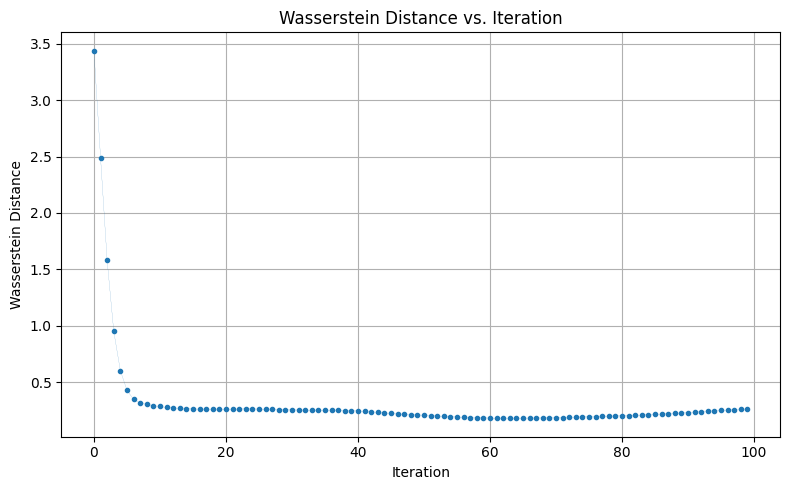

In [11]:
# Plotting how the Wasserstein distance evolves over the first 100 iterations
plt.figure(figsize=(8, 5))
plt.plot(wasserstein_history[0:100], marker='.', linestyle='-', linewidth=0.1)
plt.xlabel('Iteration')
plt.ylabel('Wasserstein Distance')
plt.title('Wasserstein Distance vs. Iteration')
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
# Compute the transported version of each source sample 
transported_samples = np.array([compute_transport_map(x, beta, Y, b, epsilon) for x in X])
print(transported_samples.max())
print(transported_samples.min())

12.292074467854436
-12.324055764164392


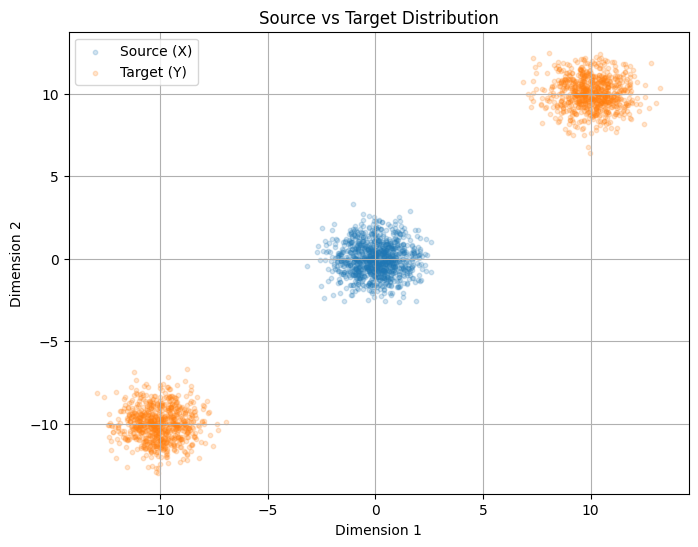

In [14]:
# Scatter plot comparing the original source distribution (X) and target distribution (Y)
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.2, label='Source (X)', s=10)
plt.scatter(Y[:, 0], Y[:, 1], alpha=0.2, label='Target (Y)', s=10)
plt.legend()
plt.title("Source vs Target Distribution")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()

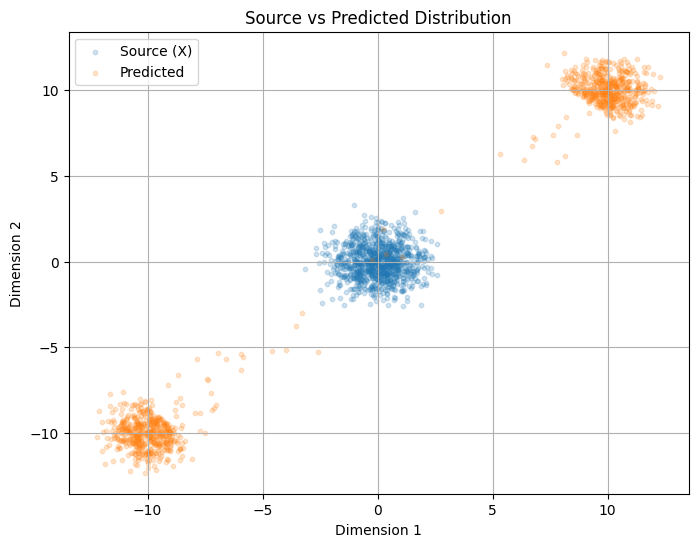

In [15]:
# Scatter plot comparing the original source distribution (X) with its transported (predicted) version
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], alpha=0.2, label='Source (X)', s=10)
plt.scatter(transported_samples[:, 0], transported_samples[:, 1], alpha=0.2, label='Predicted', s=10)
plt.legend()
plt.title("Source vs Predicted Distribution")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()